In [2]:
!pip install tensorflow

In [9]:
# Import necessary libraries
import pandas as pd
import requests

import numpy as np
import matplotlib.pyplot as plt
import tensorflow
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [ ]:


# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=IBM&outputsize=full&datatype=csv&apikey=T04GCGDEGQSVL5XP'
r = requests.get(url)


# Check if the request was successful
if r.status_code == 200:
    # Save the content as a CSV file
    with open("IBM_stock_data.csv", "wb") as file:
        file.write(r.content)
    print("CSV file saved successfully!")
else:
    print("Failed to retrieve data:", r.status_code)


In [11]:
stock_data = pd.read_csv("IBM_stock_data.csv")

In [6]:
stock_data.head()

,timestamp,open,high,low,close,volume
0,2024-10-04,223.75,226.08,223.270,226.00,3554328
1,2024-10-03,219.50,222.83,219.270,222.72,3788265
2,2024-10-02,218.31,220.20,215.798,219.73,3343399
3,2024-10-01,220.63,221.10,215.900,219.35,3548374
4,2024-09-30,220.65,221.32,219.020,221.08,3544264


In [7]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6272 entries, 0 to 6271
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  6272 non-null   object 
 1   open       6272 non-null   float64
 2   high       6272 non-null   float64
 3   low        6272 non-null   float64
 4   close      6272 non-null   float64
 5   volume     6272 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 294.1+ KB


In [8]:
stock_data.tail()

,timestamp,open,high,low,close,volume
6267,1999-11-05,92.75,92.94,90.19,90.25,13737600
6268,1999-11-04,94.44,94.44,90.00,91.56,16697600
6269,1999-11-03,95.87,95.94,93.50,94.37,10369100
6270,1999-11-02,96.75,96.81,93.69,94.81,11105400
6271,1999-11-01,98.50,98.81,96.37,96.75,9551800


In [12]:
# Convert 'timestamp' to datetime format and set it as the index
stock_data['timestamp'] = pd.to_datetime(stock_data['timestamp'])
stock_data.set_index('timestamp', inplace=True)

# Check for missing or duplicated values
missing_values = stock_data.isnull().sum()
duplicated_values = stock_data.duplicated().sum()
print("Missing values per column:\n", missing_values)
print("Number of duplicated rows:", duplicated_values)

Missing values per column:
 open      0
high      0
low       0
close     0
volume    0
dtype: int64
Number of duplicated rows: 0


In [13]:
# Feature Engineering
# Calculate daily return as percentage
stock_data['daily_return'] = stock_data['close'].pct_change() * 100

# Calculate moving averages (7-day, 30-day, and 90-day) for the close price
stock_data['MA_7'] = stock_data['close'].rolling(window=7).mean()
stock_data['MA_30'] = stock_data['close'].rolling(window=30).mean()
stock_data['MA_90'] = stock_data['close'].rolling(window=90).mean()

# Calculate daily volatility as the range (high - low) percentage of the open price
stock_data['daily_volatility'] = ((stock_data['high'] - stock_data['low']) / stock_data['open']) * 100

# Display the first few rows of the enhanced dataset
stock_data.head()



,open,high,low,close,volume,daily_return,MA_7,MA_30,MA_90,daily_volatility
timestamp,,,,,,,,,,
2024-10-04,223.75,226.08,223.270,226.00,3554328,NaN,NaN,NaN,NaN,1.255866
2024-10-03,219.50,222.83,219.270,222.72,3788265,-1.451327,NaN,NaN,NaN,1.621868
2024-10-02,218.31,220.20,215.798,219.73,3343399,-1.342493,NaN,NaN,NaN,2.016399
2024-10-01,220.63,221.10,215.900,219.35,3548374,-0.172940,NaN,NaN,NaN,2.356887
2024-09-30,220.65,221.32,219.020,221.08,3544264,0.788694,NaN,NaN,NaN,1.042375


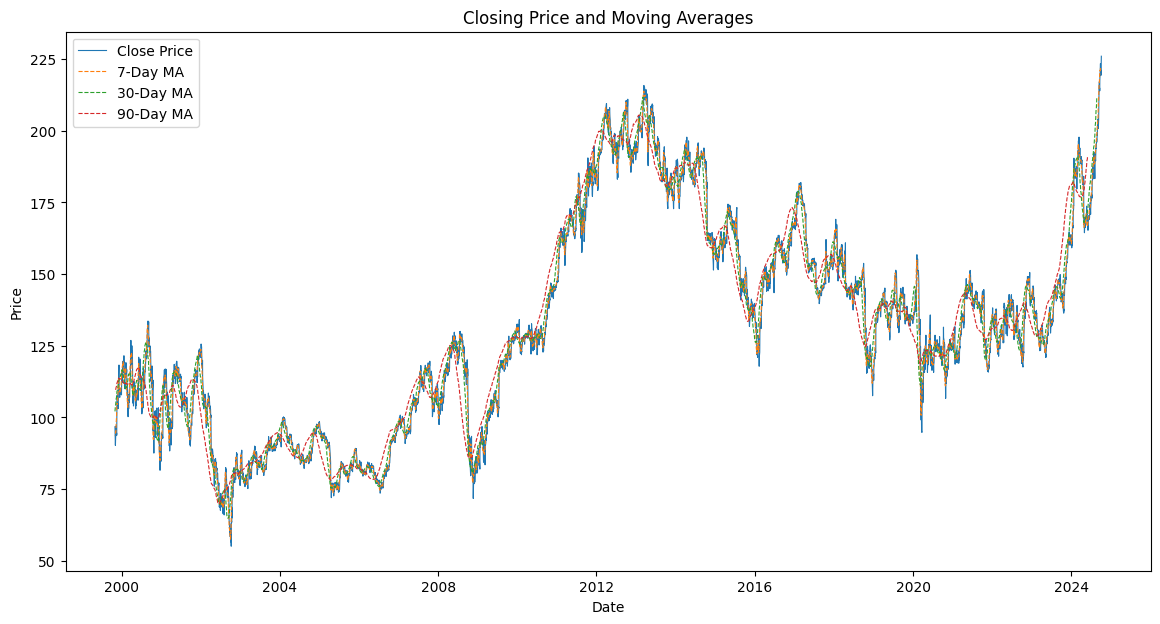

In [14]:
# Plot 1: Closing Price with Moving Averages
plt.figure(figsize=(14, 7))
plt.plot(stock_data['close'], label='Close Price', linewidth=0.8)
plt.plot(stock_data['MA_7'], label='7-Day MA', linestyle='--', linewidth=0.8)
plt.plot(stock_data['MA_30'], label='30-Day MA', linestyle='--', linewidth=0.8)
plt.plot(stock_data['MA_90'], label='90-Day MA', linestyle='--', linewidth=0.8)
plt.title('Closing Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

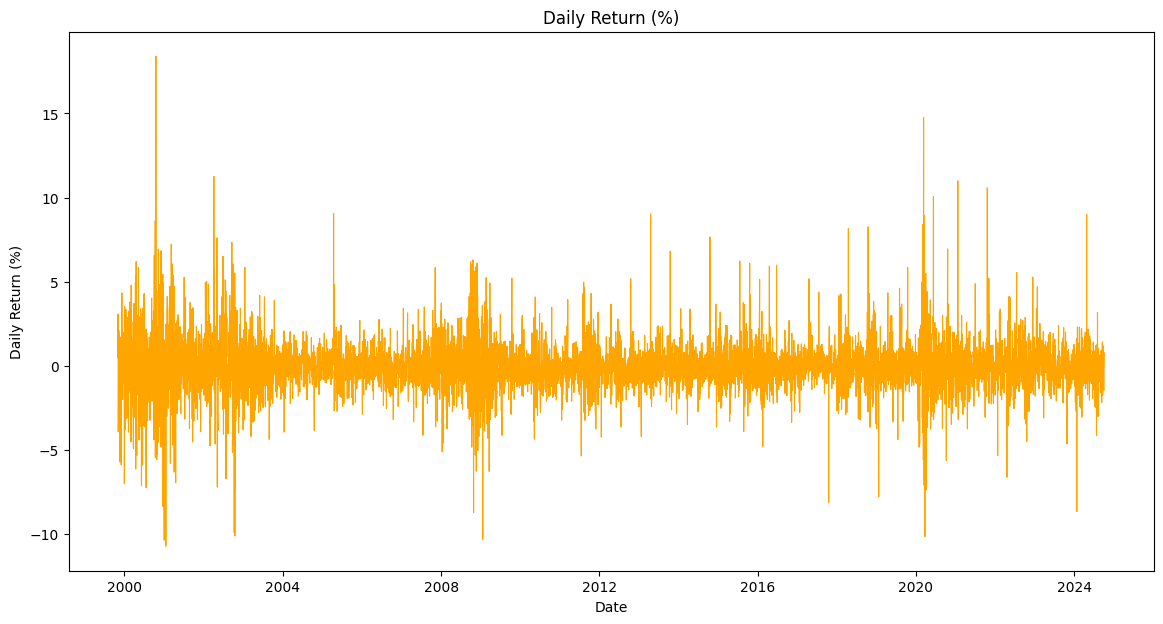

In [15]:

# Plot 2: Daily Return
plt.figure(figsize=(14, 7))
plt.plot(stock_data['daily_return'], color='orange', linewidth=0.8)
plt.title('Daily Return (%)')
plt.xlabel('Date')
plt.ylabel('Daily Return (%)')
plt.show()

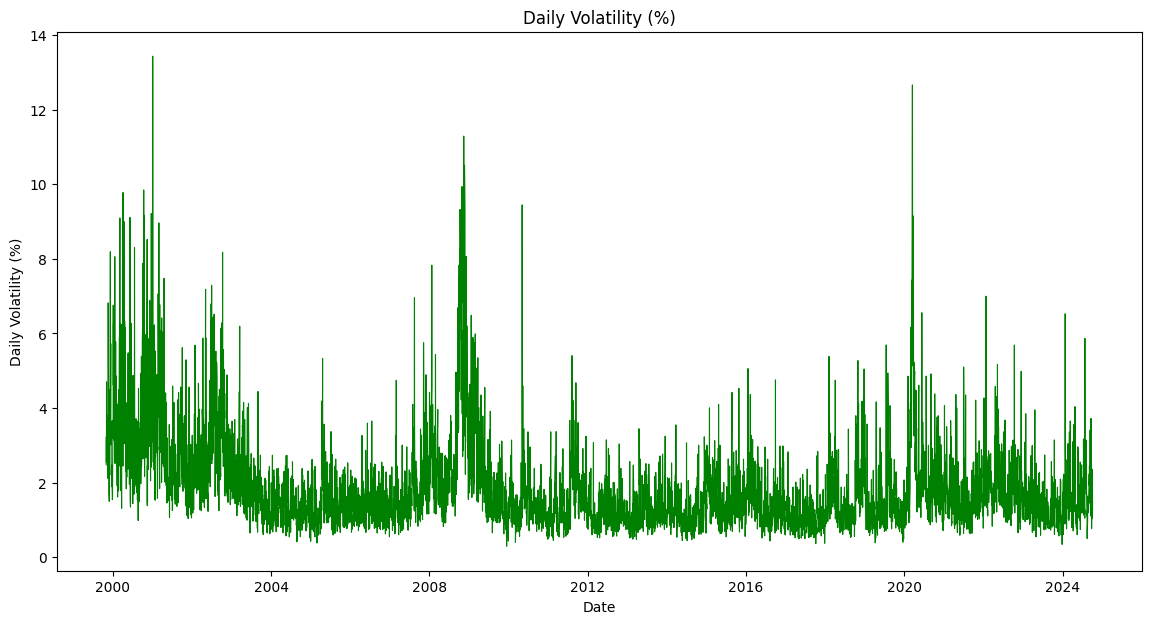

In [16]:
# Plot 3: Daily Volatility
plt.figure(figsize=(14, 7))
plt.plot(stock_data['daily_volatility'], color='green', linewidth=0.8)
plt.title('Daily Volatility (%)')
plt.xlabel('Date')
plt.ylabel('Daily Volatility (%)')
plt.show()



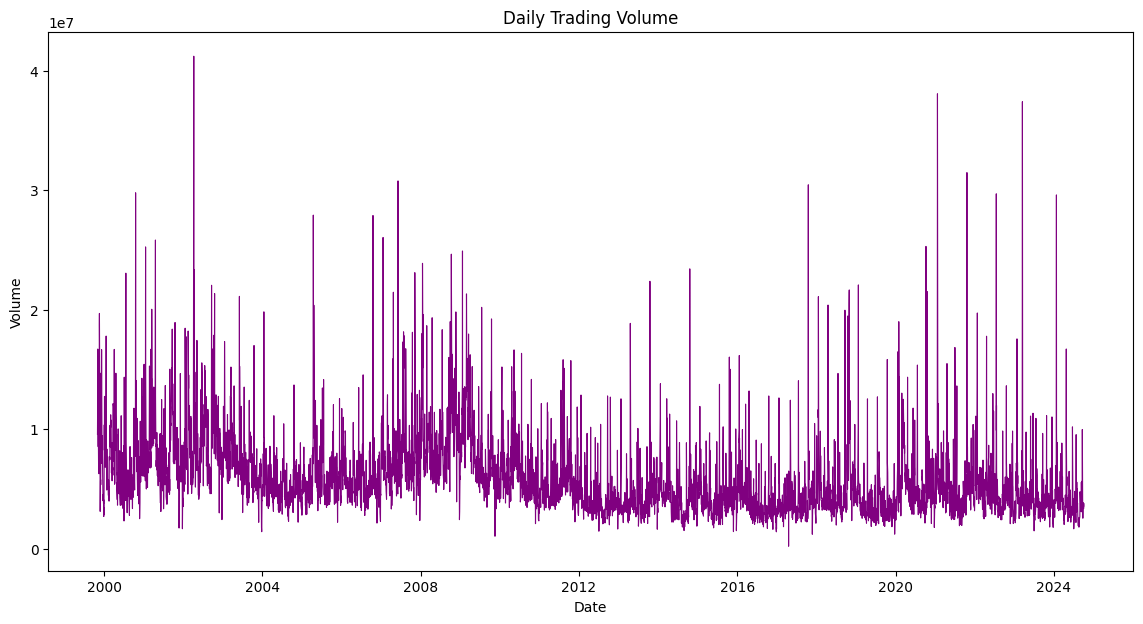

In [17]:

# Plot 4: Volume
plt.figure(figsize=(14, 7))
plt.plot(stock_data['volume'], color='purple', linewidth=0.8)
plt.title('Daily Trading Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

In [18]:
# Select only the closing price column for prediction
closing_data = stock_data[['close']]

In [19]:
# Scale the data to be between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_data)

# Split data into train and test sets (80% train, 20% test)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Define a function to create sequences
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Create sequences for the training and testing sets
seq_length = 60  # using the past 60 days to predict the next day
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Reshape data to 3D for LSTM input (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)



Shape of X_train: (4957, 60, 1)
Shape of y_train: (4957, 1)
Shape of X_test: (1195, 60, 1)
Shape of y_test: (1195, 1)


In [20]:
# Build the LSTM model
model = Sequential()

# Add LSTM layers with dropout to prevent overfitting
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Add the output layer
model.add(Dense(units=1))  # predicting the closing price

# Compile the model with optimizer and loss function
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model architecture
model.summary()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 60, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Train the LSTM model
epochs = 20
batch_size = 64

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                    validation_data=(X_test, y_test), shuffle=False)



Epoch 1/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 19s 245ms/step - loss: 0.0084 - val_loss: 0.0011
Epoch 2/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 14s 159ms/step - loss: 0.0048 - val_loss: 8.0966e-04
Epoch 3/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - loss: 0.0029 - val_loss: 6.9937e-04
Epoch 4/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - loss: 0.0023 - val_loss: 6.1171e-04
Epoch 5/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - loss: 0.0021 - val_loss: 6.2298e-04
Epoch 6/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 18s 205ms/step - loss: 0.0020 - val_loss: 6.2080e-04
Epoch 7/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 14s 122ms/step - loss: 0.0021 - val_loss: 6.0516e-04
Epoch 8/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - loss: 0.0021 - val_loss: 5.4816e-04
Epoch 9/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - loss: 0.0020 - val_loss: 6.6650e-04
Epoch 10/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - loss: 0.0021 - val_loss: 6.4423e-04
Epoch 11/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 19s 112ms/step - loss: 0.0021 - val_loss: 7.9439e-04
Epo

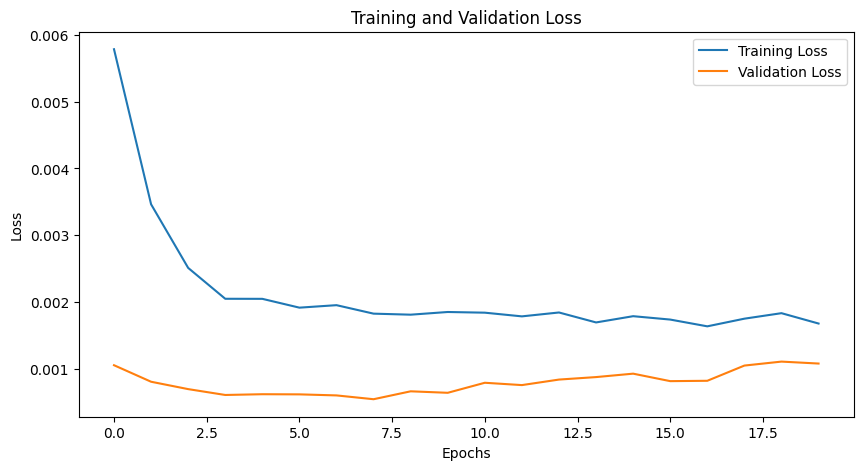

In [23]:
# Plot training and validation loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step


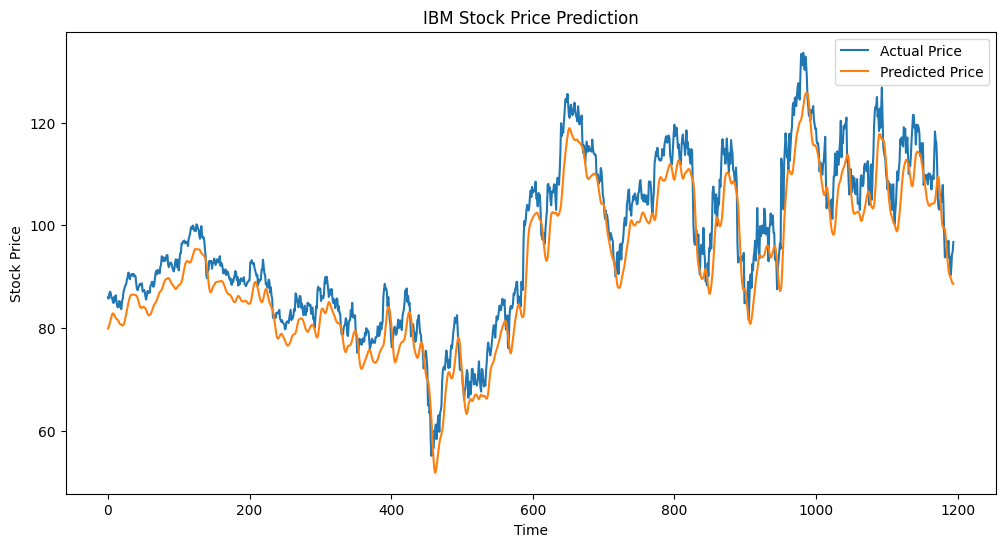

In [24]:
# Make predictions and inverse transform the scaled predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test)

# Plot actual vs predicted closing prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Price')
plt.plot(predictions, label='Predicted Price')
plt.title('IBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()



In [25]:

from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate evaluation metrics
mse = mean_squared_error(y_test_actual, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")



Mean Squared Error (MSE): 31.609207792668517
Root Mean Squared Error (RMSE): 5.6222066657735486
Mean Absolute Error (MAE): 4.773736208736149


The evaluation metrics provide a quantitative assessment of the model's prediction accuracy:

- MSE of 31.61 indicates the average squared error
between predicted and actual values.
-RMSE of 5.62, the square root of MSE, provides an error measure comparable to the original scale of the data.
-MAE of 4.77 shows the average absolute deviation from the actual values.

These values suggest that, on average, the model's predictions are around **$4.77 off from the actual price**, with some larger deviations as indicated by the RMSE.